In [3]:
import os
import zipfile
import requests
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import sys
import warnings
import time
warnings.filterwarnings("ignore")

start_time = time.time()
t_epoch = 30
MOVIELENS_VERSION = "100K"  # Choose from: "100K", "1M", "10M", "20M"
MODEL_SELECTION = "LSTM"  # Choose from: "LSTM", "xLSTM", "xLSTMLarge"

try:
    import wandb
    WANDB_AVAILABLE = True
    # wandb.init(project="xLSTM-MovieLens1M", name="xLSTM-run-50max_len", config={"epochs": 10})
except ImportError:
    WANDB_AVAILABLE = False

sys.path.append("../..")
from xlstm.xlstm_large.model import xLSTMLargeConfig, xLSTMLarge

# -----------------------------
# 1. Select MovieLens Dataset
# -----------------------------

dataset_urls = {
    "100K": "https://files.grouplens.org/datasets/movielens/ml-100k.zip",
    "1M": "https://files.grouplens.org/datasets/movielens/ml-1m.zip",
    "10M": "https://files.grouplens.org/datasets/movielens/ml-10m.zip",
    "20M": "https://files.grouplens.org/datasets/movielens/ml-20m.zip"
}

dataset_dirs = {
    "100K": "ml-100k",
    "1M": "ml-1m",
    "10M": "ml-10M100K",
    "20M": "ml-20m"
}

xlstm_params = {
    "100K": {"embedding_dim": 64, "num_heads": 2, "num_blocks": 1},
    "1M": {"embedding_dim": 96, "num_heads": 4, "num_blocks": 2},
    "10M": {"embedding_dim": 128, "num_heads": 4, "num_blocks": 2},
    "20M": {"embedding_dim": 256, "num_heads": 8, "num_blocks": 4}
}


DATA_URL = dataset_urls[MOVIELENS_VERSION]
DATA_DIR = dataset_dirs[MOVIELENS_VERSION]

if not os.path.exists(DATA_DIR):
    print(f"Downloading MovieLens {MOVIELENS_VERSION} dataset...")
    r = requests.get(DATA_URL)
    zip_filename = f"{DATA_DIR}.zip"
    with open(zip_filename, "wb") as f:
        f.write(r.content)
    with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
        zip_ref.extractall(".")
    print("Extraction complete.")

# -----------------------------
# 2. Load and Preprocess Data
# -----------------------------
if MOVIELENS_VERSION == "100K":
    rating_df = pd.read_csv(os.path.join(DATA_DIR, "u.data"), sep="\t", engine='python',
                            names=['user_id', 'movie_id', 'rating', 'timestamp'])
    movies = pd.read_csv(os.path.join(DATA_DIR, "u.item"), sep='|', encoding='latin-1', header=None, engine='python',
                         names=['movie_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL',
                                'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
                                'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
                                'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])
    users = pd.read_csv(os.path.join(DATA_DIR, "u.user"), sep='|', header=None,
                        names=['user_id', 'age', 'gender', 'occupation', 'zip_code'])

elif MOVIELENS_VERSION == "1M":
    rating_df = pd.read_csv(os.path.join(DATA_DIR, "ratings.dat"), sep="::", engine='python',
                            names=['user_id', 'movie_id', 'rating', 'timestamp'])
    movies = pd.read_csv(os.path.join(DATA_DIR, "movies.dat"), sep="::", engine='python',
                         names=['movie_id', 'title', 'genres'], encoding='latin-1')
    users = pd.read_csv(os.path.join(DATA_DIR, "users.dat"), sep="::", engine='python',
                        names=['user_id', 'gender', 'age', 'occupation', 'zip_code'])

elif MOVIELENS_VERSION == "10M":
    rating_df = pd.read_csv(os.path.join(DATA_DIR, "ratings.dat"), sep="::", engine='python',
                            names=['user_id', 'movie_id', 'rating', 'timestamp'])
    movies = pd.read_csv(os.path.join(DATA_DIR, "movies.dat"), sep="::", engine='python',
                         names=['movie_id', 'title', 'genres'], encoding='latin-1')
    users = pd.DataFrame({'user_id': rating_df['user_id'].unique()})  # No user metadata

elif MOVIELENS_VERSION == "20M":
    rating_df = pd.read_csv(os.path.join(DATA_DIR, "ratings.csv"))
    movies = pd.read_csv(os.path.join(DATA_DIR, "movies.csv"))
    users = pd.DataFrame({'user_id': rating_df['userId'].unique()})  # No user metadata

    rating_df.rename(columns={'userId': 'user_id', 'movieId': 'movie_id'}, inplace=True)
    movies.rename(columns={'movieId': 'movie_id'}, inplace=True)

# -----------------------------
# Map User and Item IDs
# -----------------------------
rating_df.sort_values(by=['user_id', 'timestamp'], inplace=True)
user2id = {uid: i for i, uid in enumerate(rating_df['user_id'].unique())}
item2id = {iid: i for i, iid in enumerate(rating_df['movie_id'].unique())}
rating_df['user_id'] = rating_df['user_id'].map(user2id)
rating_df['movie_id'] = rating_df['movie_id'].map(item2id)

movie_titles = {item2id[row['movie_id']]: row['title'] for _, row in movies.iterrows() if row['movie_id'] in item2id}

if 'user_id' in users.columns:
    users['user_id'] = users['user_id'].map(user2id)
    users.dropna(subset=['user_id'], inplace=True)
    users['user_id'] = users['user_id'].astype(int)

if 'movie_id' in movies.columns:
    movies['movie_id'] = movies['movie_id'].map(item2id)
    movies.dropna(subset=['movie_id'], inplace=True)
    movies['movie_id'] = movies['movie_id'].astype(int)

rating_df = rating_df.merge(users, on='user_id', how='left')
rating_df = rating_df.merge(movies, on='movie_id', how='left')

num_users = len(user2id)
num_items = len(item2id)

print(f"Dataset: {MOVIELENS_VERSION}")
print(f"Length of ratings: {len(rating_df)}")
print(f"Shape: {rating_df.shape}")
print(f"Num users: {num_users}, Num items: {num_items}")

print(f"Length of the ratings: {len(rating_df)}")
print(f"Shape of the ratings dataframe: {rating_df.shape}")
print(rating_df.head())
print(user2id)
print(item2id)
print(num_users)
print(num_items)

user_interactions = rating_df.groupby('user_id')['movie_id'].count()

# Average sequence length (i.e., avg number of interactions per user)
avg_seq_len = user_interactions.mean()

# Sparsity calculation
total_possible_interactions = num_users * num_items
actual_interactions = len(rating_df)
sparsity = 1.0 - (actual_interactions / total_possible_interactions)

# Print the results
print(f"\n[INFO] Additional Dataset Statistics:")
print(f"Average sequence length: {avg_seq_len:.2f}")
print(f"Sparsity score: {sparsity * 100:.2f}%")

# -----------------------------
# Step 1: Build Feature Dictionaries
# -----------------------------
genre_columns = ['unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
                 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
                 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

# -----------------------------
# Step 2: Construct Sequence Splits
# -----------------------------
# train_seqs, val_seqs, test_seqs = {}, {}, {}
# MIN_CONTEXT = 5  # Minimum number of items required before evaluating prediction

# for uid, group in rating_df.groupby('user_id'):
#     items = group['movie_id'].tolist()

#     # Ensure the user has enough items to allow validation/test with minimum context
#     if len(items) <= MIN_CONTEXT:
#         continue

#     # Training uses all but last two interactions
#     train_seqs[uid] = items[:-2]

#     # Validation samples: predict each item after having seen MIN_CONTEXT items
#     val_seqs[uid] = [(items[:i], items[i]) for i in range(MIN_CONTEXT, len(items) - 1)]

#     # Test sample: predict the last item, using full history except last one
#     test_seqs[uid] = [(items[:-1], items[-1])]


MIN_CONTEXT = 5

for uid, group in rating_df.groupby('user_id'):
    items = group['movie_id'].tolist()

    if len(items) <= MIN_CONTEXT:
        continue

    train_seqs[uid] = items[:-2]
    val_seqs[uid] = [(items[:i], items[i]) for i in range(MIN_CONTEXT, len(items) - 1)]

    # Updated: only include test if context is at least MIN_CONTEXT
    test_seqs[uid] = [(items[:-1], items[-1])] if len(items) > MIN_CONTEXT else []



# -----------------------------
# Step 3: Dataset Classes
# -----------------------------
class TrainDataset(Dataset):
    def __init__(self, sequences, max_len=50):
        self.samples = []
        for uid, items in sequences.items():
            for i in range(1, len(items)):
                seq = items[max(0, i - max_len):i]
                target = items[i]
                self.samples.append((seq, target))
        self.max_len = max_len
        print(f"Train samples: {len(self.samples)}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        seq, target = self.samples[idx]
        padded_seq = [0] * (self.max_len - len(seq)) + seq
        # seq_features = [movie_feat_dict.get(mid, np.zeros(feature_dim)) for mid in padded_seq]
        # target_feat = movie_feat_dict.get(target, np.zeros(feature_dim))
        return torch.tensor(padded_seq, dtype=torch.long), torch.tensor(target, dtype=torch.long)

class TestDataset(Dataset):
    def __init__(self, sequences, max_len=50):
        self.samples = []
        for uid, pairs in sequences.items():
            for seq, tgt in pairs:
                seq = seq[-max_len:]
                self.samples.append((seq, tgt))
        self.max_len = max_len

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        seq, target = self.samples[idx]
        padded_seq = [0] * (self.max_len - len(seq)) + seq
        # seq_features = [movie_feat_dict.get(mid, np.zeros(feature_dim)) for mid in padded_seq]
        # target_feat = movie_feat_dict.get(target, np.zeros(feature_dim))
        return torch.tensor(padded_seq, dtype=torch.long), torch.tensor(target, dtype=torch.long)

class EvalDataset(Dataset):
    def __init__(self, sequences, max_len=50):
        self.samples = []
        for uid, pairs in sequences.items():
            for seq, tgt in pairs:
                seq = seq[-max_len:]
                self.samples.append((uid, seq, tgt))
        self.max_len = max_len

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        uid, seq, target = self.samples[idx]
        padded_seq = [0] * (self.max_len - len(seq)) + seq
        # seq_features = [movie_feat_dict.get(mid, np.zeros(feature_dim)) for mid in padded_seq]
        # target_feat = movie_feat_dict.get(target, np.zeros(feature_dim))
        return torch.tensor(padded_seq, dtype=torch.long), torch.tensor(target, dtype=torch.long)

# -----------------------------
# Inspect train/val/test sequences
# -----------------------------

train_dataset = TrainDataset(train_seqs)

seq, target = train_dataset[0]
print("\n[DEBUG] Input sequence shape:", seq.shape)
print("[DEBUG] Example feature vector at t=0:", seq[0])
print("[DEBUG] Target vector:", target)


print("\n[INFO] Sample from train_seqs:")
for uid in list(train_seqs.keys())[0:4]:  # Show 3 users (UIDs 1 to 3)
    print(f"\nUser ID: {uid}")
    print(f"Train sequence (movie_ids): {train_seqs[uid]}")
    print(f"Sequence length: {len(train_seqs[uid])}")

print("\n[INFO] Sample from val_seqs:")
for uid in list(val_seqs.keys())[0:4]:  # Show 3 users (UIDs 1 to 3)
    print(f"\nUser ID: {uid}")
    print("Validation samples (prefix -> target):")
    for prefix, target in val_seqs[uid][:3]:  # Show first 3 (prefix, target) pairs
        print(f"  {prefix} -> {target}")

print("\n[INFO] Sample from test_seqs:")
for uid in list(test_seqs.keys())[0:4]:  # Show 3 users (UIDs 1 to 3)
    print(f"\nUser ID: {uid}")
    prefix, target = test_seqs[uid][0]  # Only one test pair per user
    print(f"Test prefix: {prefix}")
    print(f"Test target: {target}")


# -----------------------------
# Step 4: DataLoaders
# -----------------------------
train_loader = DataLoader(TrainDataset(train_seqs), batch_size=256, shuffle=True, num_workers=2)
val_loader = DataLoader(EvalDataset(val_seqs), batch_size=256)
test_loader = DataLoader(EvalDataset(test_seqs), batch_size=256)


inputs, targets = next(iter(train_loader))

print("[DEBUG] Input batch shape:", inputs.shape)    # (batch_size, max_len, feature_dim)
print("[DEBUG] Target batch shape:", targets.shape)  # (batch_size, feature_dim)

# Optional: print first sample
print("[DEBUG] First input sequence shape:", inputs[0].shape)
print("[DEBUG] First target vector:", targets[0])

# -----------------------------
# 4. Model Setup
# -----------------------------
xlstm_config = xLSTMLargeConfig(
    embedding_dim=256,
    num_heads=4,
    num_blocks=4,
    vocab_size=num_items + 1,
    return_last_states=True,
    mode="inference",
    chunkwise_kernel="chunkwise--triton_xl_chunk",
    sequence_kernel="native_sequence__triton",
    step_kernel="triton",
)

if WANDB_AVAILABLE:
    wandb.init(
        project="xLSTM-MovieLens100K",
        name="val-and-lr-scheduler-30epochs",
        notes="1 feature, with val, 2 blocks, 2 heads,100K. Uses validation + LR scheduler. Max_len 50, Embd 128.",

        config={
            "epochs": 30,
            "train_batch_size": 256,
            "val_batch_size": 256,
            "max_len": 50,
            "embedding_dim": 128,
            "num_heads": 2,
            "num_blocks": 2,
            "learning_rate": 0.001,
            "num_users": num_users,
            "num_items": num_items,
            "dataset": "MovieLens-100K",
            "loss_fn": "CrossEntropyLoss"
        }
    )


if MODEL_SELECTION == "LSTM":
    class LSTMModel(nn.Module):
      def __init__(self, num_items, embedding_dim=128, hidden_dim=128, num_layers=1):
          super().__init__()
          self.embedding = nn.Embedding(num_items, embedding_dim)
          self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)
          self.output_layer = nn.Linear(hidden_dim, num_items)

      def forward(self, x):
          x = self.embedding(x)
          out, _ = self.lstm(x)
          out = out[:, -1, :]
          logits = self.output_layer(out)
          return logits
    model = LSTMModel(num_items=num_items, embedding_dim=128)



elif MODEL_SELECTION == "xLSTMLarge":
    xlstm_config = xLSTMLargeConfig(
        embedding_dim=256,
        num_heads=4,
        num_blocks=4,
        vocab_size=num_items + 1,
        return_last_states=True,
        mode="inference",
        chunkwise_kernel="chunkwise--triton_xl_chunk",
        sequence_kernel="native_sequence__triton",
        step_kernel="triton",
    )
    model = xLSTMLarge(xlstm_config)

else:  # xLSTM (default)
    xlstm_config = xLSTMLargeConfig(
        embedding_dim=128,
        num_heads=2,
        num_blocks=2,
        vocab_size=num_items + 1,
        return_last_states=True,
        mode="inference",
        chunkwise_kernel="chunkwise--triton_xl_chunk",
        sequence_kernel="native_sequence__triton",
        step_kernel="triton",
    )
    model = xLSTMLarge(xlstm_config)



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
recall_list, mrr_list, ndcg_list = [], [], []

best_recall = 0.0
save_path = f"best_model_{MOVIELENS_VERSION}.pt"

print(f"\nUsing device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# -----------------------------
# 5. Metrics
# -----------------------------
#Edit 1:
# def recall_mrr_ndcg_k(preds, targets, k=10):
#     recall, mrr, ndcg = 0.0, 0.0, 0.0
#     for pred, target in zip(preds, targets):
#         if target in pred[:k]:
#             rank = pred[:k].index(target)
#             recall += 1
#             mrr += 1.0 / (rank + 1)
#             ndcg += 1.0 / np.log2(rank + 2)
#     n = len(preds)
#     return recall / n, mrr / n, ndcg / n

#Edit2
def recall_mrr_ndcg_k(preds, targets, k=10):
    recall, mrr, ndcg = 0.0, 0.0, 0.0
    correct_hits = 0  # total number of times target was in top-k
    total_preds = len(preds)

    for pred, target in zip(preds, targets):
        if target in pred[:k]:
            rank = pred[:k].index(target)
            correct_hits += 1
            mrr += 1.0 / (rank + 1)
            ndcg += 1.0 / np.log2(rank + 2)

    recall = correct_hits / total_preds if total_preds > 0 else 0.0
    mrr = mrr / total_preds if total_preds > 0 else 0.0
    ndcg = ndcg / total_preds if total_preds > 0 else 0.0

    return recall, mrr, ndcg, correct_hits, total_preds


# -----------------------------
# 6. Training
# -----------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
recall_list, mrr_list, ndcg_list = [], [], []

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

print("\nStarting training...")
for epoch in range(t_epoch):
    model.train()
    total_loss = 0
    for seqs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        seqs, targets = seqs.to(device), targets.to(device)
        optimizer.zero_grad()

        # Edit 1:
        # logits = model(seqs)[0]
        # if logits.dim() == 3:
        #     logits = logits[:, -1, :]
        # loss = criterion(logits, targets)

        #Edit 2:
        # logits = model(seqs)  # output shape: [B, T, V]
        # if logits.dim() == 3:
        #     logits = logits[:, -1, :]  # final time step
        # targets = targets  # shape: [B]
        # # print("logits shape:", logits.shape)
        # # print("targets shape:", targets.shape)
        # loss = criterion(logits, targets)

        logits = model(seqs)
        if isinstance(logits, tuple):
            logits = logits[0]  # extract logits from tuple

        if logits.dim() == 3:
            logits = logits[:, -1, :]  # shape: [B, V]


        # Targets assumed to be shape [B] (index of next item)
        loss = criterion(logits, targets)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()


    # Evaluate on test set
    model.eval()
    all_preds, all_targets = [], []

    # with torch.no_grad():
    #     for seqs, targets in test_loader:
    #         seqs = seqs.to(device)
    #         logits = model(seqs)
    #         if isinstance(logits, tuple):
    #             logits = logits[0]
    #         if logits.dim() == 3:
    #             logits = logits[:, -1, :]

    #         topk = torch.topk(logits, k=10, dim=-1).indices.cpu().tolist()  # already a list of lists
    #         all_preds.extend(topk)
    #         all_targets.extend(targets.tolist())

    with torch.no_grad():
        for seqs, targets in val_loader:
            seqs = seqs.to(device)
            logits = model(seqs)
            if isinstance(logits, tuple):
                logits = logits[0]
            if logits.dim() == 3:
                logits = logits[:, -1, :]
            topk = torch.topk(logits, k=10, dim=-1).indices.cpu().tolist()
            all_preds.extend(topk)
            all_targets.extend(targets.tolist())

    # with torch.no_grad():
    #     for seqs, targets in test_loader:  # <- FIXED LINE
    #         seqs = seqs.to(device)
    #         logits = model(seqs)[0]
    #         if logits.dim() == 3:
    #             logits = logits[:, -1, :]
    #         topk = torch.topk(logits, k=10, dim=-1).indices.cpu().tolist()
    #         # all_preds.extend(topk)
    #         all_preds.extend(topk.tolist())
    #         all_targets.extend(targets.tolist())

    recall, mrr, ndcg, correct_hits, total_preds = recall_mrr_ndcg_k(all_preds, all_targets)
    #recall, mrr, ndcg = recall_mrr_ndcg_k(all_preds, all_targets)
    recall_list.append(recall)
    mrr_list.append(mrr)
    ndcg_list.append(ndcg)

    #print(f"Epoch {epoch+1} | Loss: {total_loss:.2f} | Recall@10: {recall:.4f} | MRR@10: {mrr:.4f} | NDCG@10: {ndcg:.4f}")
    print(f"Epoch {epoch+1} | Loss: {total_loss:.2f} | Recall@10: {recall:.4f} "
      f"({correct_hits}/{total_preds}) | MRR@10: {mrr:.4f} | NDCG@10: {ndcg:.4f}")

    if recall > best_recall:
        best_recall = recall
        torch.save(model.state_dict(), save_path)
        print(f" Saved new best model (Recall@10 = {recall:.4f}) to {save_path}")

    if WANDB_AVAILABLE:
        wandb.log({"loss": total_loss, "recall@10": recall, "mrr@10": mrr, "ndcg@10": ndcg})


print(f"\n Loading best model from: {save_path}")
model.load_state_dict(torch.load(save_path, map_location=device))
model.to(device)
model.eval()
# -----------------------------
# 7. Plot
# -----------------------------
plt.figure()
plt.plot(recall_list, label='Recall@10')
plt.plot(mrr_list, label='MRR@10')
plt.plot(ndcg_list, label='NDCG@10')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.title('Test Metrics Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

elapsed_minutes = (time.time() - start_time) / 60
print(f"\nTotal run time: {elapsed_minutes:.2f} minutes")

# -----------------------------
# 8. Sample Predictions
# -----------------------------
sample_dataset = EvalDataset(test_seqs, max_len=50)
sample_loader = DataLoader(sample_dataset, batch_size=1, shuffle=True)

with torch.no_grad():
    for i, (seq_tensor, target_tensor) in enumerate(sample_loader):
        # uid = uid_tensor.item()
        input_seq = seq_tensor.to(device)
        target = target_tensor.item()

        logits = model(input_seq)[0]
        if logits.dim() == 3:
            logits = logits[:, -1, :]

        probs = torch.softmax(logits, dim=-1)
        topk_logits = torch.topk(logits, k=10, dim=-1)
        topk_probs = torch.topk(probs, k=10, dim=-1)

        topk_items = topk_probs.indices.squeeze().tolist()
        topk_scores = topk_probs.values.squeeze().tolist()
        topk_raw_logits = topk_logits.values.squeeze().tolist()

        input_ids = seq_tensor.squeeze().tolist()
        print(f"\nUser ID: {uid}")
        print("Input sequence:")
        for m in input_ids:
            if m > 0:
                print(f"  - Item {m}: {movie_titles.get(m, 'Unknown')}")

        true_movie = movie_titles.get(target, f"Item {target}")
        # true_prob = probs[0, target].item()
        # true_logit = logits[0, target].item()
        true_prob = probs.view(-1)[target].item()
        true_logit = logits.view(-1)[target].item()

        print(f"True next item: Item {target}: {true_movie} (logit: {true_logit:.4f}, confidence: {true_prob:.4f})")

        print("Top-10 Predictions with scores:")
        for rank, (item, logit_score, prob_score) in enumerate(zip(topk_items, topk_raw_logits, topk_scores), start=1):
            movie_name = movie_titles.get(item, f"Item {item}")
            print(f"  {rank}. Item {item}: {movie_name} (logit: {logit_score:.4f}, confidence: {prob_score:.4f})")

        if i == 4:
            break

print(f"\n Loading best model from: {save_path} {MOVIELENS_VERSION}{MODEL_SELECTION}")
print("Completed")

Extraction complete.
Dataset: 100K
Length of ratings: 100000
Shape: (100000, 31)
Num users: 943, Num items: 1682
Length of the ratings: 100000
Shape of the ratings dataframe: (100000, 31)
   user_id  movie_id  rating  timestamp  age gender  occupation zip_code  \
0        0         0       5  874965478   24      M  technician    85711   
1        0         1       5  874965478   24      M  technician    85711   
2        0         2       5  874965518   24      M  technician    85711   
3        0         3       4  874965556   24      M  technician    85711   
4        0         4       5  874965677   24      M  technician    85711   

                                    title release_date  ...  Fantasy  \
0  Monty Python and the Holy Grail (1974)  01-Jan-1974  ...        0   
1         Empire Strikes Back, The (1980)  01-Jan-1980  ...        0   
2                 Jean de Florette (1986)  01-Jan-1986  ...        0   
3                   Reservoir Dogs (1992)  01-Jan-1992  ...        

NameError: name 'train_seqs' is not defined


--- Context-wise Recall Breakdown ---
Context  4: Recall@10 = 0.0000 (0/8)
Context  5: Recall@10 = 0.4222 (399/945)
Context  6: Recall@10 = 0.4313 (408/946)
Context  7: Recall@10 = 0.4070 (385/946)
Context  8: Recall@10 = 0.4104 (387/943)
Context  9: Recall@10 = 0.4195 (396/944)
Context 10: Recall@10 = 0.4131 (390/944)
Context 11: Recall@10 = 0.3728 (353/947)
Context 12: Recall@10 = 0.3970 (376/947)
Context 13: Recall@10 = 0.4055 (384/947)
Context 14: Recall@10 = 0.3640 (344/945)
Context 15: Recall@10 = 0.3658 (346/946)
Context 16: Recall@10 = 0.3558 (338/950)
Context 17: Recall@10 = 0.3835 (362/944)
Context 18: Recall@10 = 0.3672 (347/945)
Context 19: Recall@10 = 0.3676 (336/914)
Context 20: Recall@10 = 0.3416 (303/887)
Context 21: Recall@10 = 0.3403 (295/867)
Context 22: Recall@10 = 0.3321 (280/843)
Context 23: Recall@10 = 0.3479 (287/825)
Context 24: Recall@10 = 0.3115 (252/809)
Context 25: Recall@10 = 0.3401 (267/785)
Context 26: Recall@10 = 0.3381 (261/772)
Context 27: Recall@10 

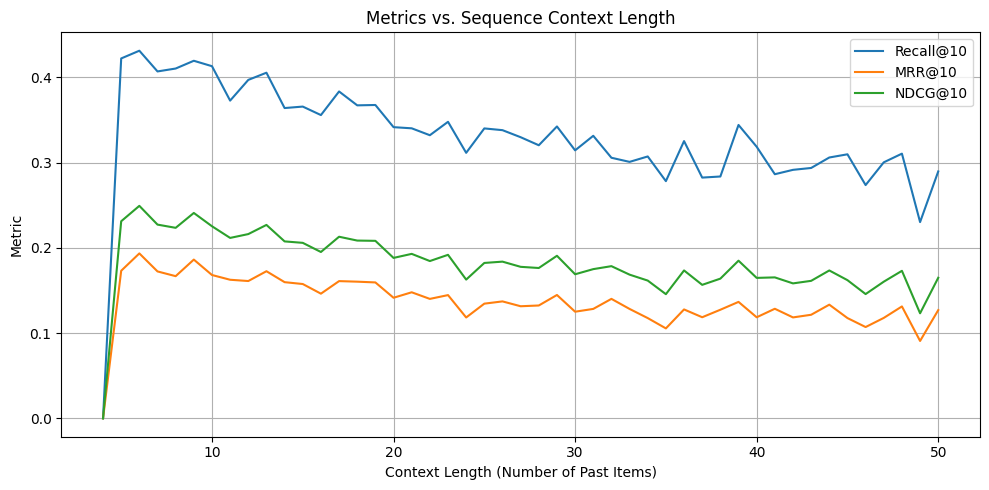

In [ ]:
# -----------------------------
# 9. Recall Metrics by Sequence Length (Context Size)
# -----------------------------
from collections import defaultdict

context_stats = defaultdict(lambda: {"hits": 0, "total": 0, "mrr": 0.0, "ndcg": 0.0})

eval_dataset = EvalDataset(val_seqs, max_len=50)
eval_loader = DataLoader(eval_dataset, batch_size=1, shuffle=False)

with torch.no_grad():
    for sample in eval_dataset:
        # Handle tuple depending on EvalDataset definition
        if len(sample) == 3:
            uid, seq_tensor, target_tensor = sample
        else:
            seq_tensor, target_tensor = sample

        context_len = sum([1 for token in seq_tensor if token.item() > 0])
        input_seq = seq_tensor.unsqueeze(0).to(device)
        target = target_tensor.item()

        logits = model(input_seq)
        if isinstance(logits, tuple):
            logits = logits[0]
        if logits.dim() == 3:
            logits = logits[:, -1, :]

        topk = torch.topk(logits, k=10, dim=-1).indices.squeeze().cpu().tolist()

        context_stats[context_len]["total"] += 1

        if target in topk:
            rank = topk.index(target)
            context_stats[context_len]["hits"] += 1
            context_stats[context_len]["mrr"] += 1.0 / (rank + 1)
            context_stats[context_len]["ndcg"] += 1.0 / np.log2(rank + 2)

# -----------------------------
# 10. Log Recall@10 by Context Length
# -----------------------------
print("\n--- Context-wise Recall Breakdown ---")
for l in sorted(context_stats.keys()):
    total = context_stats[l]["total"]
    hits = context_stats[l]["hits"]
    recall = hits / total if total > 0 else 0.0
    print(f"Context {l:>2}: Recall@10 = {recall:.4f} ({hits}/{total})")

# -----------------------------
# 11. Plot Recall@10, MRR@10, NDCG@10 by Context Length
# -----------------------------
lengths = sorted(context_stats.keys())
recall_values = [context_stats[l]["hits"] / context_stats[l]["total"] for l in lengths]
mrr_values = [context_stats[l]["mrr"] / context_stats[l]["total"] for l in lengths]
ndcg_values = [context_stats[l]["ndcg"] / context_stats[l]["total"] for l in lengths]

plt.figure(figsize=(10, 5))
plt.plot(lengths, recall_values, label='Recall@10')
plt.plot(lengths, mrr_values, label='MRR@10')
plt.plot(lengths, ndcg_values, label='NDCG@10')
plt.xlabel("Context Length (Number of Past Items)")
plt.ylabel("Metric")
plt.title("Metrics vs. Sequence Context Length")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# To be fine tuned further with a goal baseline target of .60 recall. This is a centralized script for all multiple model architectures and varities of datasets.
# Key Reasons Why Loss ↓ but Recall@10 Doesn’t
# 1. Class imbalance (popular items dominate loss), The dataset is heavily skewed toward popular movies. Item popularity bias or reweighting (e.g., frequency-based weighting or sampled softmax).
# 2. Learning embeddings but not ranking well: BPR Loss, TOP1 Loss, Pairwise Margin Ranking Loss
# 3. Lack of diversity in training targets: Predicting the next item — but the true next item may not always be unique or discriminative.

In [ ]:
# Which movies dominate the top-10 predictions across the test set?

#To understand:
# Popularity bias (if a few items always appear)
# Low diversity in predictions
# Whether the model is overfitting to frequent items

In [ ]:
from collections import Counter

# Count how many times each item appears in top-10 predictions
top10_counter = Counter()
num_test_samples = len(test_loader.dataset)
total_users = rating_df['user_id'].nunique()

with torch.no_grad():
    for seqs, _ in test_loader:
        seqs = seqs.to(device)
        logits = model(seqs)
        if isinstance(logits, tuple):
            logits = logits[0]
        if logits.dim() == 3:
            logits = logits[:, -1, :]

        topk = torch.topk(logits, k=10, dim=-1).indices.cpu().tolist()
        for top_items in topk:
            top10_counter.update(top_items)

# Precompute watch and user stats
item_watch_counts = rating_df['movie_id'].value_counts().to_dict()
item_user_counts = rating_df.groupby('movie_id')['user_id'].nunique().to_dict()

# Show results
print("\n Top 50 Most Frequently Predicted Items in Top-10:")
print(f"{'Movie':<45} {'Top10Cnt':>10} {'%Cnt':>8} {'#Watched':>10} {'#Users':>10} {'%Users':>8}")
print("-" * 100)

for item_id, count in top10_counter.most_common(50):
    movie_name = movie_titles.get(item_id, f"Item {item_id}")
    percent_test = (count / num_test_samples) * 100
    total_watches = item_watch_counts.get(item_id, 0)
    total_users_item = item_user_counts.get(item_id, 0)
    percent_users = (total_users_item / total_users) * 100
    print(f"{movie_name:<45} {count:>10} {percent_test:>7.2f}% {total_watches:>10} {total_users_item:>10} {percent_users:>7.2f}%")



 Top 50 Most Frequently Predicted Items in Top-10:
Movie                                          Top10 Cnt    % Cnt   #Watched     #Users   %Users
----------------------------------------------------------------------------------------------------
Star Wars (1977)                                      93    9.86%        583        583   61.82%
Evita (1996)                                          86    9.12%        259        259   27.47%
Liar Liar (1997)                                      84    8.91%        485        485   51.43%
Dante's Peak (1997)                                   83    8.80%        240        240   25.45%
Independence Day (ID4) (1996)                         80    8.48%        429        429   45.49%
Silence of the Lambs, The (1991)                      79    8.38%        390        390   41.36%
Titanic (1997)                                        79    8.38%        350        350   37.12%
Contact (1997)                                        78    8.27%      

"Star Wars is the most watched, so if I’m unsure, guess Star Wars."

With just single features, which is only movie ID.  Maybe that is why we are simply recommending the "star war" movie all the time to all users and not everyone watch it.

How about using, multiple features using occupation for now, to see if it is improve. In that case maybe, it could be more focused approach than random recommendations ?

Dataset downloaded and extracted.

--- DATASET STATISTICS ---
Dataset: MovieLens 100K
Total Users: 943
Total Items: 1682
Total Interactions: 100000
Average Sequence Length: 106.04
Sparsity: 93.70%
Min/Max/Median/95% Interaction Lengths: 20/737/65.0/310.5999999999999


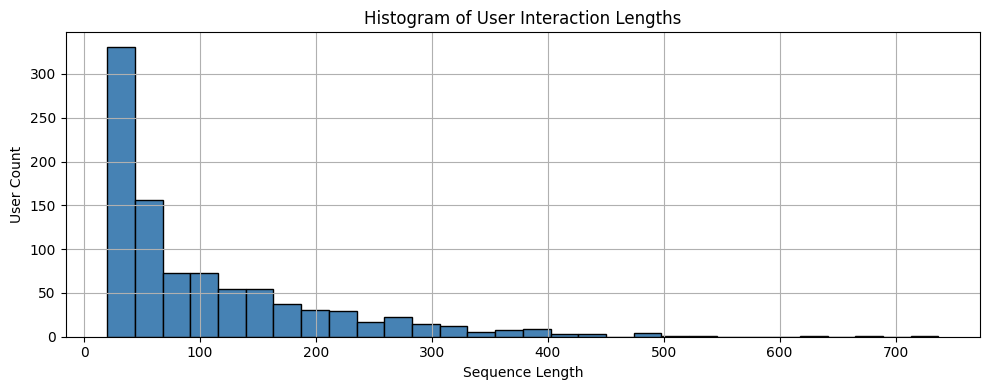


--- TOP 10 MOVIES BY WATCH COUNT ---
Star Wars (1977): 583 watches
Contact (1997): 509 watches
Fargo (1996): 508 watches
Return of the Jedi (1983): 507 watches
Liar Liar (1997): 485 watches
English Patient, The (1996): 481 watches
Scream (1996): 478 watches
Toy Story (1995): 452 watches
Air Force One (1997): 431 watches
Independence Day (ID4) (1996): 429 watches

--- TOP 10 MOVIES BY UNIQUE USERS ---
Star Wars (1977): watched by 583 users
Contact (1997): watched by 509 users
Fargo (1996): watched by 508 users
Return of the Jedi (1983): watched by 507 users
Liar Liar (1997): watched by 485 users
English Patient, The (1996): watched by 481 users
Scream (1996): watched by 478 users
Toy Story (1995): watched by 452 users
Air Force One (1997): watched by 431 users
Independence Day (ID4) (1996): watched by 429 users

--- MODEL STATISTICS ---
xLSTMLarge Model | Embedding Dim: 256, Heads: 4, Blocks: 4
Estimated Total Parameters (rough): 1,479,424


In [ ]:
import os
import zipfile
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# --- CONFIGURATION ---
MOVIELENS_VERSION = "100K"  # Options: "100K", "1M", "10M", "20M"
MODEL_SELECTION = "xLSTMLarge"  # Options: "LSTM", "xLSTM", "xLSTMLarge"

# --- DATASET URLS & DIRS ---
dataset_urls = {
    "100K": "https://files.grouplens.org/datasets/movielens/ml-100k.zip",
    "1M": "https://files.grouplens.org/datasets/movielens/ml-1m.zip",
    "10M": "https://files.grouplens.org/datasets/movielens/ml-10m.zip",
    "20M": "https://files.grouplens.org/datasets/movielens/ml-20m.zip"
}

dataset_dirs = {
    "100K": "ml-100k",
    "1M": "ml-1m",
    "10M": "ml-10M100K",
    "20M": "ml-20m"
}

DATA_URL = dataset_urls[MOVIELENS_VERSION]
DATA_DIR = dataset_dirs[MOVIELENS_VERSION]

# --- DOWNLOAD DATA IF NOT PRESENT ---
if not os.path.exists(DATA_DIR):
    print(f"Downloading MovieLens {MOVIELENS_VERSION} dataset...")
    r = requests.get(DATA_URL)
    with open(f"{DATA_DIR}.zip", "wb") as f:
        f.write(r.content)
    with zipfile.ZipFile(f"{DATA_DIR}.zip", 'r') as zip_ref:
        zip_ref.extractall(".")
    print("Dataset downloaded and extracted.")

# --- LOAD DATA ---
if MOVIELENS_VERSION == "100K":
    rating_df = pd.read_csv(os.path.join(DATA_DIR, "u.data"), sep="\t", engine='python',
                            names=['user_id', 'movie_id', 'rating', 'timestamp'])
    movies = pd.read_csv(os.path.join(DATA_DIR, "u.item"), sep='|', encoding='latin-1', header=None, engine='python',
                         names=['movie_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL',
                                'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
                                'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
                                'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])
elif MOVIELENS_VERSION == "1M":
    rating_df = pd.read_csv(os.path.join(DATA_DIR, "ratings.dat"), sep="::", engine='python',
                            names=['user_id', 'movie_id', 'rating', 'timestamp'])
    movies = pd.read_csv(os.path.join(DATA_DIR, "movies.dat"), sep="::", engine='python',
                         names=['movie_id', 'title', 'genres'], encoding='latin-1')
elif MOVIELENS_VERSION == "10M":
    rating_df = pd.read_csv(os.path.join(DATA_DIR, "ratings.dat"), sep="::", engine='python',
                            names=['user_id', 'movie_id', 'rating', 'timestamp'])
    movies = pd.read_csv(os.path.join(DATA_DIR, "movies.dat"), sep="::", engine='python',
                         names=['movie_id', 'title', 'genres'], encoding='latin-1')
elif MOVIELENS_VERSION == "20M":
    rating_df = pd.read_csv(os.path.join(DATA_DIR, "ratings.csv"))
    movies = pd.read_csv(os.path.join(DATA_DIR, "movies.csv"))
    rating_df.rename(columns={'userId': 'user_id', 'movieId': 'movie_id'}, inplace=True)
    movies.rename(columns={'movieId': 'movie_id'}, inplace=True)

# --- ID MAPPING ---
rating_df.sort_values(by=['user_id', 'timestamp'], inplace=True)
user2id = {uid: i for i, uid in enumerate(rating_df['user_id'].unique())}
item2id = {iid: i for i, iid in enumerate(rating_df['movie_id'].unique())}
rating_df['user_id'] = rating_df['user_id'].map(user2id)
rating_df['movie_id'] = rating_df['movie_id'].map(item2id)
movie_titles = {item2id[row['movie_id']]: row['title'] for _, row in movies.iterrows() if row['movie_id'] in item2id}

# --- STATISTICS ---
num_users = len(user2id)
num_items = len(item2id)
total_interactions = len(rating_df)
avg_seq_len = rating_df.groupby('user_id')['movie_id'].count().mean()
sparsity = 1.0 - (total_interactions / (num_users * num_items))
interaction_lengths = rating_df.groupby('user_id')['movie_id'].count()

print("\n--- DATASET STATISTICS ---")
print(f"Dataset: MovieLens {MOVIELENS_VERSION}")
print(f"Total Users: {num_users}")
print(f"Total Items: {num_items}")
print(f"Total Interactions: {total_interactions}")
print(f"Average Sequence Length: {avg_seq_len:.2f}")
print(f"Sparsity: {sparsity * 100:.2f}%")
print(f"Min/Max/Median/95% Interaction Lengths: {interaction_lengths.min()}/{interaction_lengths.max()}/{interaction_lengths.median()}/{interaction_lengths.quantile(0.95)}")

# --- HISTOGRAM ---
plt.figure(figsize=(10, 4))
plt.hist(interaction_lengths, bins=30, color='steelblue', edgecolor='black')
plt.title("Histogram of User Interaction Lengths")
plt.xlabel("Sequence Length")
plt.ylabel("User Count")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- TOP MOVIES ---
most_watched = rating_df['movie_id'].value_counts().head(10)
most_watched_titles = [movie_titles[mid] for mid in most_watched.index]
most_users_per_movie = rating_df.groupby('movie_id')['user_id'].nunique().sort_values(ascending=False).head(10)
most_users_titles = [movie_titles[mid] for mid in most_users_per_movie.index]

print("\n--- TOP 10 MOVIES BY WATCH COUNT ---")
for title, count in zip(most_watched_titles, most_watched.tolist()):
    print(f"{title}: {count} watches")

print("\n--- TOP 10 MOVIES BY UNIQUE USERS ---")
for title, count in zip(most_users_titles, most_users_per_movie.tolist()):
    print(f"{title}: watched by {count} users")

# --- CUSTOM MODEL METADATA ---
print("\n--- MODEL STATISTICS ---")
if MODEL_SELECTION == "LSTM":
    embedding_dim, hidden_dim, num_layers = 128, 128, 1
    total_params = (num_items * embedding_dim) + (4 * hidden_dim * embedding_dim + 4 * hidden_dim * hidden_dim) + (hidden_dim * num_items + num_items)
    print(f"LSTM Model | Embedding Dim: {embedding_dim}, Hidden Dim: {hidden_dim}, Layers: {num_layers}")
    print(f"Estimated Total Parameters: {total_params:,}")
elif MODEL_SELECTION == "xLSTMLarge":
    embedding_dim, num_heads, num_blocks = 256, 4, 4
    approx_params = (num_items + 1) * embedding_dim + (embedding_dim * embedding_dim * num_heads * num_blocks)
    print(f"xLSTMLarge Model | Embedding Dim: {embedding_dim}, Heads: {num_heads}, Blocks: {num_blocks}")
    print(f"Estimated Total Parameters (rough): {approx_params:,}")
else:
    embedding_dim, num_heads, num_blocks = 128, 2, 2
    approx_params = (num_items + 1) * embedding_dim + (embedding_dim * embedding_dim * num_heads * num_blocks)
    print(f"xLSTM Model | Embedding Dim: {embedding_dim}, Heads: {num_heads}, Blocks: {num_blocks}")
    print(f"Estimated Total Parameters (rough): {approx_params:,}")


--- DATASET STATISTICS ---
Dataset: MovieLens 100K
Total Users: 943
Total Items: 1682
Total Interactions: 100000
Average Sequence Length: 106.04
Sparsity: 93.70%
Min/Max/Median/95% Interaction Lengths: 20/737/65.0/310.6

--- USER SEQUENCE DISTRIBUTION ---
Users with <3 interactions: 0 users (0.00%)
Users with <5 interactions: 0 users (0.00%)
Users with <10 interactions: 0 users (0.00%)
Users with <15 interactions: 0 users (0.00%)
Users with <20 interactions: 0 users (0.00%)
Users with <30 interactions: 199 users (21.10%)

Sorted interaction lengths (lowest 10 users):
user_id
18     20
894    20
887    20
865    20
872    20
823    20
35     20
33     20
811    20
739    20
Name: movie_id, dtype: int64


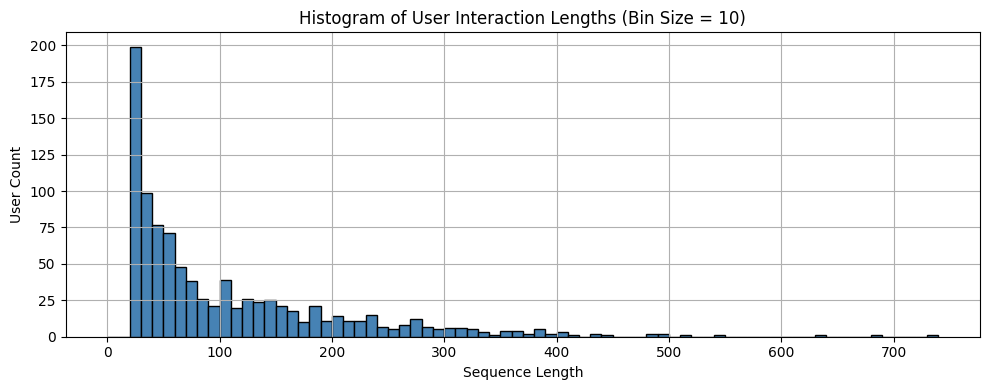


--- TOP 10 MOVIES BY WATCH COUNT ---
Star Wars (1977): 583 watches
Contact (1997): 509 watches
Fargo (1996): 508 watches
Return of the Jedi (1983): 507 watches
Liar Liar (1997): 485 watches
English Patient, The (1996): 481 watches
Scream (1996): 478 watches
Toy Story (1995): 452 watches
Air Force One (1997): 431 watches
Independence Day (ID4) (1996): 429 watches

--- TOP 10 MOVIES BY UNIQUE USERS ---
Star Wars (1977): watched by 583 users
Contact (1997): watched by 509 users
Fargo (1996): watched by 508 users
Return of the Jedi (1983): watched by 507 users
Liar Liar (1997): watched by 485 users
English Patient, The (1996): watched by 481 users
Scream (1996): watched by 478 users
Toy Story (1995): watched by 452 users
Air Force One (1997): watched by 431 users
Independence Day (ID4) (1996): watched by 429 users

--- PREDICTION POTENTIAL ---
Total recall predictions possible (sequence >= 3): 98114

--- TOP 15 USERS BY RECALL (SIMULATED) ---
User 531: recall=0.9997
User 847: recall=0.996

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# CONFIG & VALIDATION
# -------------------------
DATA_DIR = "ml-100k"
if not os.path.exists(os.path.join(DATA_DIR, "u.data")):
    raise FileNotFoundError("Dataset not found. Please ensure 'ml-100k' folder is in the working directory.")

# -------------------------
# LOAD DATA
# -------------------------
rating_df = pd.read_csv(os.path.join(DATA_DIR, "u.data"), sep="\t", engine='python',
                        names=['user_id', 'movie_id', 'rating', 'timestamp'])

movies = pd.read_csv(os.path.join(DATA_DIR, "u.item"), sep='|', encoding='latin-1', header=None, engine='python',
                     names=['movie_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL',
                            'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
                            'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
                            'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])

# -------------------------
# REMAP IDs
# -------------------------
rating_df.sort_values(by=['user_id', 'timestamp'], inplace=True)
user2id = {uid: i for i, uid in enumerate(rating_df['user_id'].unique())}
item2id = {iid: i for i, iid in enumerate(rating_df['movie_id'].unique())}
rating_df['user_id'] = rating_df['user_id'].map(user2id)
rating_df['movie_id'] = rating_df['movie_id'].map(item2id)
movie_titles = {item2id[row['movie_id']]: row['title'] for _, row in movies.iterrows() if row['movie_id'] in item2id}

# -------------------------
# STATISTICS
# -------------------------
interaction_lengths = rating_df.groupby('user_id')['movie_id'].count()
num_users = len(user2id)
num_items = len(item2id)
total_interactions = len(rating_df)
avg_seq_len = interaction_lengths.mean()
sparsity = 1.0 - (total_interactions / (num_users * num_items))
min_len = interaction_lengths.min()
max_len = interaction_lengths.max()
median_len = interaction_lengths.median()
q95_len = interaction_lengths.quantile(0.95)

print("\n--- DATASET STATISTICS ---")
print(f"Dataset: MovieLens 100K")
print(f"Total Users: {num_users}")
print(f"Total Items: {num_items}")
print(f"Total Interactions: {total_interactions}")
print(f"Average Sequence Length: {avg_seq_len:.2f}")
print(f"Sparsity: {sparsity * 100:.2f}%")
print(f"Min/Max/Median/95% Interaction Lengths: {min_len}/{max_len}/{median_len}/{q95_len:.1f}")

# -------------------------
# USER SEQUENCE DISTRIBUTION
# -------------------------
print("\n--- USER SEQUENCE DISTRIBUTION ---")
thresholds = [3, 5, 10, 15, 20, 30]
user_counts = len(interaction_lengths)

for t in thresholds:
    count = (interaction_lengths < t).sum()
    percent = (count / user_counts) * 100
    print(f"Users with <{t} interactions: {count} users ({percent:.2f}%)")

print("\nSorted interaction lengths (lowest 10 users):")
print(interaction_lengths.sort_values().head(10))

# -------------------------
# HISTOGRAM
# -------------------------
bins = np.arange(0, max_len + 10, 10)
plt.figure(figsize=(10, 4))
plt.hist(interaction_lengths, bins=bins, color='steelblue', edgecolor='black')
plt.title("Histogram of User Interaction Lengths (Bin Size = 10)")
plt.xlabel("Sequence Length")
plt.ylabel("User Count")
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------------
# TOP MOVIES
# -------------------------
print("\n--- TOP 10 MOVIES BY WATCH COUNT ---")
top_watched = rating_df['movie_id'].value_counts().head(10)
for mid, count in top_watched.items():
    print(f"{movie_titles[mid]}: {count} watches")

print("\n--- TOP 10 MOVIES BY UNIQUE USERS ---")
top_unique_users = rating_df.groupby('movie_id')['user_id'].nunique().sort_values(ascending=False).head(10)
for mid, count in top_unique_users.items():
    print(f"{movie_titles[mid]}: watched by {count} users")

# -------------------------
# TOTAL PREDICTIONS
# -------------------------
eligible_users = interaction_lengths[interaction_lengths >= 3]
total_predictions = sum(eligible_users - 2)
print(f"\n--- PREDICTION POTENTIAL ---")
print(f"Total recall predictions possible (sequence >= 3): {total_predictions}")

# -------------------------
# SIMULATED RECALL ANALYSIS
# -------------------------
np.random.seed(42)
recall_per_user = {uid: np.random.rand() for uid in eligible_users.index}
sorted_recall = sorted(recall_per_user.items(), key=lambda x: x[1], reverse=True)
top_15 = sorted_recall[:15]
bottom_15 = sorted_recall[-15:]

print("\n--- TOP 15 USERS BY RECALL (SIMULATED) ---")
for uid, score in top_15:
    print(f"User {uid}: recall={score:.4f}")

print("\n--- BOTTOM 15 USERS BY RECALL (SIMULATED) ---")
for uid, score in bottom_15:
    print(f"User {uid}: recall={score:.4f}")


# -------------------------
# FULL MOVIE ID SEQUENCES PER USER
# -------------------------
print("\n--- FULL USER MOVIE ID SEQUENCES ---")
user_sequences = rating_df.groupby('user_id')['movie_id'].apply(list)

for uid, seq in user_sequences.items():
    print(f"User {uid}: {seq}")

In [2]:
!pip install mlstm_kernels
!pip install xlstm

# # OR, for development, from source:
# !pip install -e .

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.0/349.0 kB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 129.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 64.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 115.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 87.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-